In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('project2.ok')

Assignment: Project 2: Cardiovascular Disease: Causes, Treatment, and Prevention
OK, version v1.18.1



# Cardiovascular Disease: Causes, Treatment, and Prevention

In this project, I will investigate the major causes of death in the world: cardiovascular disease! 

In [6]:
# Don't change this cell

from client.api.notebook import *
def new_save_notebook(self):
    """ Saves the current notebook by
        injecting JavaScript to save to .ipynb file.
    """
    try:
        from IPython.display import display, Javascript
    except ImportError:
        log.warning("Could not import IPython Display Function")
        print("Make sure to save your notebook before sending it to OK!")
        return

    if self.mode == "jupyter":
        display(Javascript('IPython.notebook.save_checkpoint();'))
        display(Javascript('IPython.notebook.save_notebook();'))
    elif self.mode == "jupyterlab":
        display(Javascript('document.querySelector(\'[data-command="docmanager:save"]\').click();'))   

    print('Saving notebook...', end=' ')

    ipynbs = [path for path in self.assignment.src
              if os.path.splitext(path)[1] == '.ipynb']
    # Wait for first .ipynb to save
    if ipynbs:
        if wait_for_save(ipynbs[0]):
            print("Saved '{}'.".format(ipynbs[0]))
        else:
            log.warning("Timed out waiting for IPython save")
            print("Could not automatically save \'{}\'".format(ipynbs[0]))
            print("Make sure your notebook"
                  " is correctly named and saved before submitting to OK!".format(ipynbs[0]))
            return False                
    else:
        print("No valid file sources found")
    return True

def wait_for_save(filename, timeout=600):
    """Waits for FILENAME to update, waiting up to TIMEOUT seconds.
    Returns True if a save was detected, and False otherwise.
    """
    modification_time = os.path.getmtime(filename)
    start_time = time.time()
    while time.time() < start_time + timeout:
        if (os.path.getmtime(filename) > modification_time and
            os.path.getsize(filename) > 0):
            return True
        time.sleep(0.2)
    return False

Notebook.save_notebook = new_save_notebook
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
np.set_printoptions(legacy='1.13')

from client.api.notebook import Notebook
ok = Notebook('project2.ok')
_ = ok.auth(inline=True)

Assignment: Project 2: Cardiovascular Disease: Causes, Treatment, and Prevention
OK, version v1.18.1

Successfully logged in as michellefan@berkeley.edu


In the following analysis, I will investigate the world's most dangerous killer: Cardiovascular Disease. I'll look at decades of medical research, and multiple causes and effects across four different studies.

Here is a roadmap for this project:

* In Part 1, I'll investigate the major causes of death in the world during the past century (from 1900 to 2015).
* In Part 2, I'll look at data from the Framingham Heart Study, an observational study into cardiovascular health.
* In Part 3, I'll examine the effect that hormone replacement therapy has on the risk of coronary heart disease for post-menopausal women using data from the Nurses' Heart Study and Heart and Estrogen-Progestin Replacement Study.
* In Part 4, I'll explore the effect that the consumption of saturated fats has on cardiovascular death rates using data from the National Heart-Diet Study

## Part 1: Causes of Death 

In order to get a better idea of how we can most effectively prevent deaths, we need to first figure out what the major causes of death are. Here is the `causes_of_death` table, which documents the death rate for major causes of deaths over the last century (1900 until 2015).

In [7]:
causes_of_death = Table.read_table('causes_of_death.csv')
causes_of_death.show(5)

Year,Cause,Age Adjusted Death Rate
2015,Heart Disease,168.5
2015,Cancer,158.5
2015,Stroke,37.6
2015,Accidents,43.2
2015,Influenza and Pneumonia,15.2


Each entry in the column **Age Adjusted Death Rate** is a death rate for a specific **Year** and **Cause** of death. 

If we look at unadjusted data, the age distributions of each sample will influence death rates. In an older population, we would expect death rates to be higher for all causes since old age is associated with higher risk of death. To compare death rates without worrying about differences in the demographics of our populations, we adjust the data for age.

The **Age Adjusted** specification in the death rate column tells us that the values shown are the death rates that would have existed if the population under study in a specific year had the same age distribution as the "standard" population, a baseline. 

**Unique Causes of Death:** All the different causes of death in this dataset. 

In [8]:
unique_causes = np.unique(causes_of_death.column("Cause"))
sorted(unique_causes)

['Accidents', 'Cancer', 'Heart Disease', 'Influenza and Pneumonia', 'Stroke']

**Disease Over Time:** We would like to plot the death rate for each disease over time. 

Creating a table called `causes_for_plotting`.

In [10]:
def first(x):
    return x.item(0)

In [11]:
causes_for_plotting = causes_of_death.pivot('Cause', 'Year', 'Age Adjusted Death Rate', first)
causes_for_plotting.show(5)

Year,Accidents,Cancer,Heart Disease,Influenza and Pneumonia,Stroke
1900,90.3,114.8,265.4,297.5,244.2
1901,109.3,118.1,272.6,312.9,243.6
1902,93.6,119.7,285.2,219.3,237.8
1903,106.9,125.2,304.5,251.1,244.6
1904,112.8,127.9,331.5,291.2,255.2


Let's take a look at how age-adjusted death rates have changed across different causes over time. The cell below will compare Heart Disease (a chronic disease) and Influenza and Pneumonia (infectious diseases).

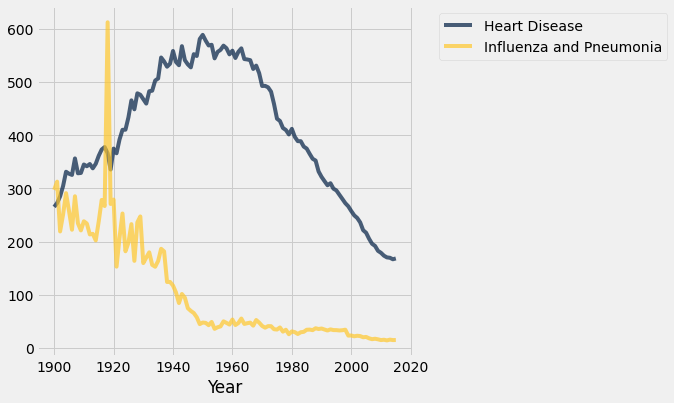

In [12]:
causes_for_plotting.select('Year', "Heart Disease", "Influenza and Pneumonia").plot('Year')

This phenomenon is known as the epidemiological transition - in developed countries, the severity of infectious disease has decreased, but chronic disease has become more widespread. Coronary heart disease (CHD) is one of the most deadly chronic diseases that has emerged in the past century, and more healthcare resources have been invested to studying it.

The cell below shows what a plot of the data would have looked like had you been living in 1950. CHD was the leading cause of death and had killed millions of people without warning. It had become twice as lethal in just a few decades and people didn't understand why this was happening.

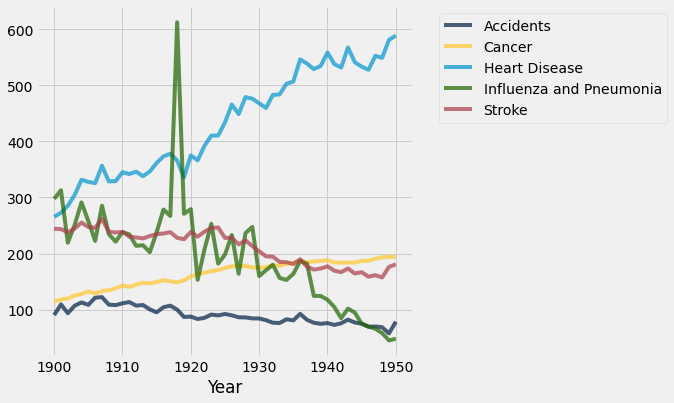

In [13]:
causes_for_plotting.where('Year', are.below_or_equal_to(1950)).plot('Year')

The view from 2016 looks a lot less scary, however, since we know it eventually went down. The decline in CHD deaths is one of the greatest public health triumphs of the last half century. That decline represents many millions of saved lives, and it was not inevitable. The Framingham Heart Study, in particular, was the first to discover the associations between heart disease and risk factors like smoking, high cholesterol, high blood pressure, obesity, and lack of exercise.

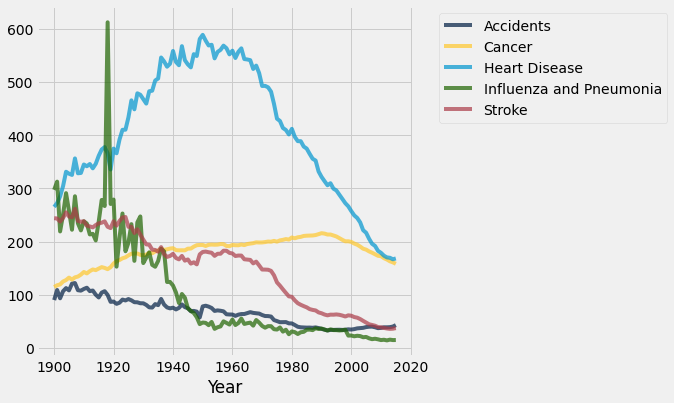

In [14]:
causes_for_plotting.plot('Year')

Let's examine the graph above. You'll see that in the 1960s, the death rate due to heart disease steadily declines. Up until then, the effects of smoking, blood pressure, and diet on the cardiovascular system were unknown to researchers. Once these factors started to be noticed, doctors were able recommend a lifestyle change for at-risk patients to prevent heart attacks and heart problems.

Note, however, that the death rate for heart disease is still higher than the death rates of all other causes. Even though the death rate is starkly decreasing, there's still a lot we don't understand about the causes (both direct and indirect) of heart disease.

## Part 2: The Framingham Heart Study

The [Framingham Heart Study](https://en.wikipedia.org/wiki/Framingham_Heart_Study) is an observational study of cardiovascular health. The initial study followed over 5,000 volunteers from  Framingham, Massachusetts for several decades, and followup studies even looked at their descendants. In this section, I'll investigate some of the study's key findings about cholesterol and heart disease.

The cell below examines data for 3842 subjects from the first wave of the study, collected in 1956.

In [15]:
framingham = Table.read_table('framingham.csv')
framingham

AGE,SYSBP,DIABP,TOTCHOL,CURSMOKE,DIABETES,GLUCOSE,DEATH,ANYCHD
39,106,70,195,0,0,77,0,1
46,121,81,250,0,0,76,0,0
48,127.5,80,245,1,0,70,0,0
61,150,95,225,1,0,103,1,0
46,130,84,285,1,0,85,0,0
43,180,110,228,0,0,99,0,1
63,138,71,205,0,0,85,0,1
45,100,71,313,1,0,78,0,0
52,141.5,89,260,0,0,79,0,0
43,162,107,225,1,0,88,0,0


Each row contains data from one subject. The first seven columns describe the subject at the time of their initial medical exam at the start of the study. The last column, `ANYCHD`, tells us whether the subject developed some form of heart disease at any point after the start of the study; a value of 1 indicates that they **did** develop heart disease and a value of 0 indicates that they **did not** develop heart disease.

You may have noticed that the table contains fewer rows than subjects in the original study - I'll exclude subjects who already had heart disease or had missing data.

### Section 1: Diabetes and the Population

Before I begin our investigation into cholesterol, I'll first look at some limitations of this dataset. In particular, I will investigate ways in which this is or isn't a representative sample of the population by examining the number of subjects with diabetes.

[According to the CDC](https://www.cdc.gov/diabetes/statistics/slides/long_term_trends.pdf), the prevalence of diagnosed diabetes (i.e., the percentage of the population who have it) in the U.S. around this time was 0.93%. We are going to conduct a hypothesis test with the following null and alternative hypotheses:

**Null Hypothesis**: The probability that a participant within the Framingham Study has diabetes is equivalent to the prevalence of diagnosed diabetes within the population. (i.e., any difference is due to chance).

**Alternative Hypothesis**: The probability that a participant within the Framingham Study has diabetes is different than the prevalence of diagnosed diabetes within the population.

I'll use the absolute distance between the **observed prevalence** and the **true population prevalence** as our test statistic. The column `DIABETES` in the `framingham` table contains a 1 for subjects with diabetes and a `0` for those without.

**Test Statistic**: The observed value of the test statistic in the data from the Framingham Study.

In [16]:
observed_diabetes_distance = framingham.where("DIABETES", are.equal_to(1)).num_rows / framingham.num_rows - 0.0093
observed_diabetes_distance

0.01802951587714732

**Diabetes Test Statistic Function**: Defining the function `diabetes_test_statistic` which should return exactly one simulated statistic of the absolute distance between the observed prevalence and the true population prevalence under the null hypothesis.

In [17]:
diabetes_proportions = make_array(.9907, .0093)

def diabetes_test_statistic():
    sample = sample_proportions(framingham.num_rows, diabetes_proportions).item(1)
    return abs(sample - 0.0093)


**Simulate**:  Simulating 5000 values of the statistic under the null hypothesis.

In [18]:
diabetes_simulated_stats = make_array()

for i in np.arange(5000): 
    stat = diabetes_test_statistic()
    diabetes_simulated_stats = np.append(diabetes_simulated_stats, stat)
    
diabetes_simulated_stats

array([ 0.00137153,  0.00071072,  0.00137153, ...,  0.00227241,
        0.00397434,  0.00175185])

**Test Statistic Histogram**: I'll generate a histogram of the simulated values of your statistic, along with the observed value.

/opt/conda/lib/python3.8/site-packages/datascience/tables.py:5206: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(ticks, rotation='vertical')


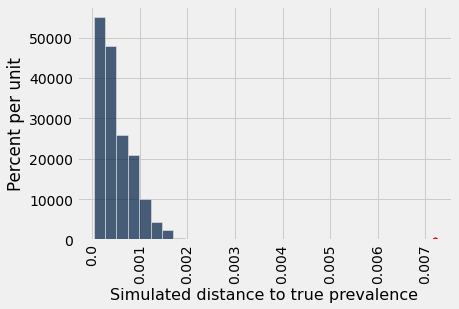

In [19]:
Table().with_column('Simulated distance to true prevalence', diabetes_simulated_stats).hist()
plots.scatter(observed_diabetes_distance, 0, color='red', s=30);

We should reject our proposed null hypothesis. This is because our observed test statistic is very, very far off to the right, where is almost no data, which means that our observed test statistic is very unlikely to appear and our p-value would definitley be less than 5%, our proposed cutoff. This means that there is evidence supporting that the probability that a participant within the Framingham Study has diabetes is different than the prevalence of diagnosed diabetes within the population.

In real-world studies, getting a truly representative random sample of the population is often incredibly difficult. Even just to accurately represent all Americans, a truly random sample would need to examine people across geographical, socioeconomic, community, and class lines (just to name a few). For a study like this, scientists would also need to make sure the medical exams were standardized and consistent across the different people being examined. In other words, there's a tradeoff between taking a more representative random sample and the cost of collecting more information from each person in the sample.

The Framingham study collected high-quality medical data from its subjects, even if the subjects may not be a perfect representation of the population of all Americans. This is a common issue that data scientists face: while the available data aren't perfect, they're the best we have. The Framingham study is generally considered the best in its class, so we'll continue working with it while keeping its limitations in mind.

(For more on representation in medical study samples, you can read these recent articles from [NPR](https://www.npr.org/sections/health-shots/2015/12/16/459666750/clinical-trials-still-dont-reflect-the-diversity-of-america) and [Scientific American](https://www.scientificamerican.com/article/clinical-trials-have-far-too-little-racial-and-ethnic-diversity/)).

### Section 2: Cholesterol and Heart Disease

In the remainder of this question, I'll examine one of the main findings of the Framingham study: an association between serum cholesterol (i.e., how much cholesterol is in someone's blood) and whether or not that person develops heart disease.

I'll use the following null and alternative hypotheses:

**Null Hypothesis:** In the population, the distribution of cholesterol levels among those who get heart disease is the same as the distribution of cholesterol levels
among those who do not.

**Alternative Hypothesis:** The cholesterol levels of people in the population who get
heart disease are higher, on average, than the cholesterol level of people who do not.

**A/B Testing:** It seems reasonable to use A/B Testing to determine which model is more consistent.

**My Test Statistic:** The test statistic should be the average cholesterol level of people with heart disease minus the average choloesterol level of people without heart disease. We chose this because our alternative hypothesis is a one sided test (we are only interested if the cholesterol level is *higher* in heart disease than those without). 

**Test Statistic Function**: Function that computes your test statistic. Takes a table with two columns, `TOTCHOL` (total serum cholesterol) and `ANYCHD` (whether or not the person had coronary heart disease), and compute the test statistic I described above. 

In [20]:
def framingham_test_statistic(tbl):
    chd = np.average(tbl.where("ANYCHD", are.equal_to(1)).column('TOTCHOL'))
    nochd = np.average(tbl.where("ANYCHD", are.equal_to(0)).column("TOTCHOL"))
    return chd - nochd 
framingham_observed_statistic = framingham_test_statistic(framingham)
framingham_observed_statistic

16.635919905689406

**Hypothesis Testing**: I'll write a function to simulate the test statistic under the null hypothesis, defining a function to simulate the test statistic under the null hypothesis, and then I'll use that function 1000 times to understand the distribution under the null hypothesis. 

In [22]:
chdframingham = framingham.select("TOTCHOL", "ANYCHD")
def simulate_framingham_null():
    shuffled = chdframingham.sample(with_replacement = False).column("TOTCHOL")
    withshuffled = chdframingham.select("ANYCHD").with_column("TOTCHOL", shuffled)
    return framingham_test_statistic(withshuffled)
simulate_framingham_null()

framingham_simulated_stats = make_array()

for i in np.arange(500):
    stats = simulate_framingham_null()
    framingham_simulated_stats = np.append(framingham_simulated_stats, stats)

**Test Statistic Histogram:** I'll plot the histogram of the simulated test statistics, as well as a point for the observed test statistic. 

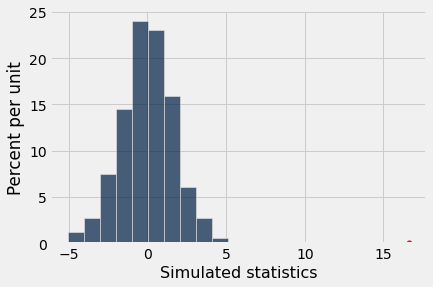

In [23]:
Table().with_column('Simulated statistics', framingham_simulated_stats).hist()
plots.scatter(framingham_observed_statistic, 0, color='red', s=30);

**P-Value**: Computing the p-value for this hypothesis test.

In [24]:
framingham_p_val = np.count_nonzero(framingham_simulated_stats >= framingham_observed_statistic) / 500
framingham_p_val

0.0

We cannot that say that high cholesterol causes heart diesease because there is evidence that there is  an association based on the p-value we got for the simulated test statistics. Since our p-value is 0, there is evidence that people with heart disease may have higher cholesterol levels, but we cannot say that it causes heart disease. There could be confounding factors such as diet and income that affects both the exposure and the outcome, or high cholesterol and heart disease. The Framingham Heart Study is not representative of the population at large, which is a major limitation that prevents us from concluding that high cholesterol *causes* heart disease. The Framinghaam Heart Study is also categorized as an observational sample, and is not a randomized control trial. Therefore, we can only reach conclusions about association, and not causation. 

Similar studies from the 1950s found positive associations between diets high in saturated fat, high cholesterol, and incidence of heart disease. In 1962, the U.S. Surgeon General said:

*"Although there is evidence that diet and dietary habits may be implicated in the development of coronary heart disease and may be significant in its prevention or control, at present our only research evidence is associative and not conclusive."*

## Part 3: Hormone Replacement Therapy for Cardiovascular Health

### Section 1: The Nurses' Health Study

The Nurses' Health Study (NHS) is another very large observational study which has brought many insights into women's health. It began in 1976 by Dr. Frank Speizer, with questionnaires that were mailed to 121,964 female registered nurses in the United States asking about their medical history, cholesterol and blood pressure, current medications, and so on (one of the benefits of studying nurses is their ability to give reliably accurate answers to these questions). 

The study's initial focus was on investigating the long-term health effects of oral contraceptives, whose use had become much more widespread in the U.S. during the 1960s, but the focus soon expanded to investigating a wide variety of questions on women's health. The NHS continues to this day, tracking its third generation of nurses in the US.

**One of the most consequential early findings from the NHS was about hormone replacement therapy (HRT)**: supplementary estrogen and progesterone for post-menopausal women to relieve side effects of declining hormone levels due to menopause. The NHS found that HRT in postmenopausal women was negatively associated with heart attack risk. In a landmark 1985 paper in the *New England Journal of Medicine* (NEJM), Speizer and his coauthors wrote that
> As compared with the risk in women who had never used postmenopausal hormones, the age-adjusted relative risk of coronary disease in those who had ever used them was 0.5 (95 per cent confidence limits, 0.3 and 0.8; P = 0.007)... These data support the hypothesis that the postmenopausal use of estrogen reduces the risk of severe coronary heart disease. [(Stampfer et al., 1985)](https://www.ncbi.nlm.nih.gov/pubmed/4047106)

**In other words, the authors are saying that women on HRT are half as likely to suffer a heart attack over a certain time period.** We'll define the term "relative risk" later in this section, and we'll also investigate the interpretation of these claims and their statistical basis.

**The scientists running the NHS wanted to compare post-menopausal women who had taken HRT with post-menopausal women who had never taken HRT, excluding all women who were not post-menopausal or who had previously suffered a heart attack.** This study design complicates the analysis because it creates a variety of reasons why women might drop in and out of the relevant comparison groups.

Because women could (and did) drop into and out of the comparison groups in the middle of the study, it is difficult to make a table like we usually would, with one row per participant. In medical studies, individuals are typically weighted by the *amount of time* that they enrolled in the study. A more convenient sampling unit is a **person-month at risk**, which is one month spent by a particular woman in one of the comparison groups, during which she might or might not suffer a heart attack. Here, "at risk" just means the woman is being tracked by the survey in either of the two comparison groups, so that if she had a heart attack it would be counted in our data set.

**Example**: The table below tracks the histories of two hypothetical post-menopausal women in a six-month longitudinal study, who both enter the study in January 1978:
1. Alice has never been on HRT. She has a heart attack in March and is excluded for the remainder of the study period. 
2. Beatrice begins taking HRT for the first time in April and stays healthy throughout the study period.

| Name     | Month    | HRT | Heart Attack   |                                             
|----------|----------|-----|----------------|
| Alice    | Jan 1978 |  0  | 0              |
| Alice    | Feb 1978 |  0  | 0              |
| Alice    | Mar 1978 |  0  | 1              |
| Beatrice | Jan 1978 |  0  | 0              | 
| Beatrice | Feb 1978 |  0  | 0              |
| Beatrice | Mar 1978 |  0  | 0              |
| Beatrice | Apr 1978 |  1  | 0              |
| Beatrice | May 1978 |  1  | 0              |
| Beatrice | Jun 1978 |  1  | 0              |



The probability that a heart attack will happen to a given at-risk person in a given duration of time is called the **hazard rate**. The NHS calculated its effects in terms of the **relative risk**, which is simply the hazard rate for *person-months* in the HRT (Group A) group divided by the hazard rate in the no-HRT (Group B) group.

$$\text{Relative Risk} = \frac{\text{Hazard Rate(Treatment Group)}}{\text{Hazard Rate(Control Group)}}$$


Most statistical methods that deal with this type of data assume that we can treat a table like the one above as though it is a sample of independent random draws from a much larger population of person-months at risk in each group. **We will take this assumption for granted throughout the rest of this section.**

Instead of *person-months* at risk, the NHS used *person-years* at risk. It reported 51,478 total person-years at risk in the no-HRT group with 60 heart attacks occurring in total, as well as 54,309 person-years at risk in the HRT group with 30 heart attacks occurring in total. The table NHS below has one row for each person-year at risk. The two columns are 'HRT', recording whether it came from the HRT group (1) or no-HRT group (0), and 'Heart Attack', recording whether the participant had a heart attack that year (1 for yes, 0 for no).

In [26]:
NHS = Table.read_table('NHS.csv')
NHS.show(3)

HRT,Heart Attack
0,0
0,0
0,0


Using the NHS data, we can now conduct a hypothesis test to investigate the relationship between HRT and risk of CHD. As a reminder, the **hazard rate** is defined as the proportion of people who died in a specific group out of the total number who participated in the study from that group.

> **Null Hypothesis:** HRT does not affect the risk of CHD, and the true relative risk is equal to 1. Any deviation is due to random chance

> **Alternative Hypothesis:** HRT decreases the risk of CHD, and the true relative risk is less than 1.

> **Test Statistic:** Relative risk of CHD between post-menopausal women receiving HRT and post-menopausal women not receiving HRT (the definition of relative risk is repeated here for your convenience):

$$\text{Relative Risk} = \frac{\text{Hazard Rate(Treatment Group)}}{\text{Hazard Rate(Control Group)}}$$

*Note: Remember that we assume, under the null, that the two populations are derived from the same much larger population - under this assumption $\text{Hazard Rate(Treatment Group)} = \text{Hazard Rate(Control Group)}$. After simulation, we test this hypothesis by viewing the relative_risk for our simulated samples.*

**Relative Risk Function:** Function called `relative_risk` that takes in a table with the column labels `HRT` and `Heart Attack`, and computes the sample relative risk as an estimate of the population relative risk.

In [27]:
def relative_risk(tbl):
    """Return the ratio of the hazard rates (events per person-year) for the two groups"""
    treatment = tbl.where("HRT", are.equal_to(1)).where("Heart Attack", are.equal_to(1)).num_rows / tbl.where("HRT", are.equal_to(1)).num_rows
    control = tbl.where("HRT", are.equal_to(0)).where("Heart Attack", are.equal_to(1)).num_rows / tbl.where("HRT", are.equal_to(0)).num_rows
    return treatment / control
relative_risk(NHS)

0.47393618000699694

**Bootstrap:** `one_bootstrap_rr` generates one bootstrap sample and computes the relative risk. I'll assign `bootstrap_rrs` to 15 (the code is slow!) estimates of the population relative risk.

In [28]:
def one_bootstrap_rr():
    resample = NHS.sample(NHS.num_rows, with_replacement = True)
    return relative_risk(resample)

bootstrap_rrs = make_array()
for i in np.arange(15):
    new_bootstrap_rr = one_bootstrap_rr()
    bootstrap_rrs = np.append(bootstrap_rrs, new_bootstrap_rr)

**95% Confidence Interval:** The file `bootstrap_rrs.csv` contains a one-column table with 2001 saved bootstrapped relative risks. I'll use these bootstrapped values to compute a 95% confidence interval, storing the left endpoint as `ci_left` and the right endpoint as `ci_right`. 

In [29]:
bootstrap_rrs_from_tbl = Table.read_table('bootstrap_rrs.csv').column(0)
ci_left = percentile(2.5, bootstrap_rrs_from_tbl)
ci_right = percentile(97.5, bootstrap_rrs_from_tbl)

print("Middle 95% of bootstrappped relative risks: [{:f}, {:f}]".format(ci_left, ci_right))

Middle 95% of bootstrappped relative risks: [0.295930, 0.730383]


The code below plots the confidence interval on top of the bootstrap histogram.

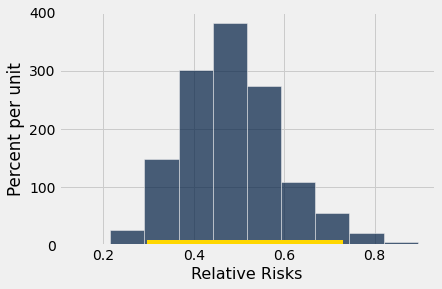

In [30]:
Table().with_column("Relative Risks", bootstrap_rrs_from_tbl).hist()
plots.plot([ci_left, ci_right], [.05,.05], color="gold");

We reject the null hypothesis because the test statistic (0) was not included in the 95% confidence interval. There was an association that was negative, which means that HRT was associated with a decreased risk of heart attacks (since the relatives risks are less than 1, which means protective effect). 

Partly as a result of evidence from the NHS and other observational studies that drew similar conclusions, HRT drugs became a very popular preventive treatment for doctors to prescribe to post-menopausal woman. Even though there were known or suspected risks to the treatment (such as increasing the risk of invasive breast cancer), it was thought that the reduction in heart disease risk was well worth it.

### Section 2: The Heart and Estrogen-Progestin Replacement Study

The Heart and Estrogen-Progestin Replacement Study (HERS) was a large randomized controlled trial carried out by the Women's Health Initiative, which sought to verify whether HRT drugs were as effective as the observational studies seemed to suggest. 2,763 women with a history of heart disease were selected and randomly assigned to receive the treatment (daily estrogen pills) or a placebo pill that looked identical to the treatment. Of the 2763 women participating, 1380 were assigned to the treatment condition and 1383 to the control. They were followed for an average of three years and the number of heart attacks in the two groups was compared.

The main results table from the HERS study [Hulley et al. (1998)](https://jamanetwork.com/journals/jama/fullarticle/187879) is reproduced here:

<img src="HERS-table.png" width=500>

For this study, we constructed our own table from scratch based on the results given above. The results are contained in the table `HERS` that has one row for each woman in the trial and two columns: `HRT`, which is 1 if she was assigned to treatment and 0 otherwise, and `CHD`, which is 1 if she suffered a Primary CHD (Coronary Heart Disease) event and 0 otherwise.

Run the cell below to view the results from the HERS study.

In [32]:
num_control = 1383 
num_treatment = 1380

num_control_chd = 176
num_treatment_chd = 172

hrt = np.append(np.zeros(num_control), np.ones(num_treatment))
chd_control = np.append(np.zeros(num_control - num_control_chd), np.ones(num_control_chd))
chd_treatment = np.append(np.zeros(num_treatment - num_treatment_chd), np.ones(num_treatment_chd))
chd = np.append(chd_control, chd_treatment)

HERS = Table().with_columns('HRT', hrt, 'CHD', chd)
HERS.show(3)

HRT,CHD
0,0
0,0
0,0


**Test Statistic:** I'd like to test the null hypothesis that the treatment (HRT) has no effect on the outcome (CHD), against the alternative hypothesis that the treatment does have an effect. Good test statistics can be: 

1. The absolute difference between 1 and the relative risk.
2. 10 times the absolute difference between the control and treatment groups' average CHD rates.

**Test Statistic:** I'll use distance (absolute difference) between average CHD rates as our test statistic. 

Function called `hers_test_statistic` will calculate this test statistic on a table with columns `HRT` and `CHD`. It will calculate the observed test statistic.

In [33]:
def HERS_test_statistic(tbl):
    """Test statistic: Distance between the average responses"""
    control = tbl.where("HRT", are.equal_to(0)).where("CHD", are.equal_to(1)).num_rows / tbl.where("HRT", are.equal_to(0)).num_rows
    treatment = tbl.where("HRT", are.equal_to(1)).where("CHD", are.equal_to(1)).num_rows / tbl.where("HRT", are.equal_to(1)).num_rows
    return abs(control - treatment)
observed_HERS_test_statistic = HERS_test_statistic(HERS)
observed_HERS_test_statistic

0.0026218994624162967

**Simulate Once:** Function called `simulate_one_HERS_statistic` will simulate one value of the test statistic under the null hypothesis. 

In [37]:
def simulate_one_HERS_statistic():
    resample = HERS.sample(HERS.num_rows, with_replacement = True)
    return HERS_test_statistic(resample)
HERS_test_statistics = make_array()
for i in np.arange(1200):
    HERS_statistic = simulate_one_HERS_statistic()
    HERS_test_statistics = np.append(HERS_test_statistics, HERS_statistic)

The code below generates a histogram of the simulated test statistics along with my test statistic:

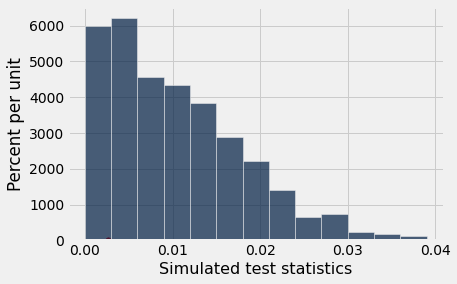

In [38]:
Table().with_column('Simulated test statistics', HERS_test_statistics).hist(bins=np.arange(0,.04,.003))
plots.scatter(HERS_test_statistic(HERS), 0, color='red', s=30);

**P-Value:** Computing the P-value for my hypothesis test.

In [39]:
HERS_pval = np.count_nonzero(HERS_test_statistics >= observed_HERS_test_statistic) / 1200
HERS_pval

0.8375

According to our test statistic, we fail to reject the null hypothesis because our calcuated p-value, 0.8341666666666666, is much larger than our 5% cutoff. Also, as seen in the given histogram, the null hypothesis for that particular test is that the relative risk is equal to 1, that there is no difference in CHD for women who have taken and have not taken HRT. As 1 is included in the 95% CI, it means that we fail to reject the null hypothesis. 

The Heart and Estrogen-Progestin Replacement Study found that HRT did not have a significant impact on a woman's risk of CHD. These findings contradicted the results of the Nurses' Heart study, challenging the efficacy of a treatment that had become the standard of care for heart disease prevention. 

The HERS study authors put forward a possible answer regarding why the NHS study might be biased:
> However, the observed association between estrogen therapy and reduced CHD risk might be attributable to selection bias if women who choose to take hormones are healthier and have a more favorable CHD profile than those who do not. Observational studies cannot resolve this uncertainty.

**Selection bias** occurs in observational studies when there is a systematic difference between participants that receive a treatment and participants that do not receive a treatment. When this type of bias is present, the observed treatment effect might be a result of an unmeasured confounding variable.

There would be selection bias in that women who take hormones are healthier to begin with, which is a systematic bias since it affects the whole sample systematically. We would expect the observational studies with selection bias to overestimate the protective effect of HRT because there would be more people who are healthier in the study than normal. 

### Further reading

If you're interested in learning more, you can check out these articles:

* [Origin story of the Framingham Heart Study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1449227/)
* [NYT article on the Nurses' Health Study and the HERS study](https://www.nytimes.com/2003/04/22/science/hormone-studies-what-went-wrong.html)

## Part 4: Diet and Cardiovascular Disease

To establish a causal link between saturated fat intake, serum cholesterol, and heart disease, a group of doctors in the US established the National Heart-Diet Study. The study was based in 6 centers: Baltimore, Boston, Chicago, Minneapolis-St. Paul, Oakland, and Faribault, MN. The first 5 centers recruited volunteers from the local population: volunteers and their families were asked to adjust their diet to include more or less saturated fat.

You may already have a strong intuition about what the doctors concluded in their findings, but the evidence from the trial was surprisingly complex.

The sixth center was organized by Dr. Ivan Frantz, and its study was known as the Minnesota Coronary Experiment. Dr. Frantz was a strong proponent of reducing saturated fats to prevent death from heart disease. He believed so strongly in the idea that he placed his household on a strict diet very low in saturated fats. The main difference between the Minnesota Coronary Experiment and the rest of the National Diet-Heart Study was the setting. While the other centers in the study looked at volunteers, Dr. Frantz conducted his study at Faribault State Hospital, which housed patients who were institutionalized due to disabilities or mental illness.

In this institution, the subjects were randomly divided into two equal groups: half of the subjects, the **control group**, were fed meals cooked with saturated fats, and the other half, the **diet group**, were fed meals cooked with polyunsaturated fats. For example, the diet group's oils were replaced with corn oils and their butter was replaced with margarine. The subjects did not know which food they were getting, to avoid any potential bias or placebo effect. This type of study is known as a **blind** study.

Although standards for informed consent in participation weren't as strict then as they are today, the study was described as follows:

*No consent forms were required because the study diets were considered to be acceptable as house diets and the testing was considered to contribute to better patient care.  Prior to beginning the diet phase, the project was explained and sample foods were served. Residents were given the opportunity to decline participation.*

Despite the level of detail and effort in the study, the results of the study were never extensively examined until the late 21st century. Over 40 years after the data were collected, Dr. Christopher Ramsden heard about the experiment, and asked Dr. Frantz's son Robert to uncover the files in the Frantz family home's dusty basement. You can learn more about the story of how the data was recovered on the [Revisionist History podcast](http://revisionisthistory.com/episodes/20-the-basement-tapes) or in [Scientific American magazine](https://www.scientificamerican.com/article/records-found-in-dusty-basement-undermine-decades-of-dietary-advice/).

**Ethical Concerns:** While the data from such a study may be useful scientifically, it also raises major ethical concerns. The study was done at a setting where its participants, who are disabled and mentally ill, may not be fully capable of making a decision to participate in the study or not, and may not understand what the risks may be for the study. Also, the study didn't emphasize consent, because they should have been given consent forms with all of the information, regardless of what was considered acceptable at the time, because the patients need to make their own decision on what is an appropriate houeshold diet or it was better for their own personal patient care. The health outcome is also not obvious, and when death is the health outcome it should be made extremely clear that the experiment might pose dangers to your health. In recent years, poor treatment of patients at Faribault State Hospital (and other similar institutions in Minnesota) has come to light: the state has recently changed patients' gravestones from numbers to their actual names, and apologized for inhumane treatment of patients.|

### The Data

I want to see whether or not death rates were reduced on low saturated fat diet. Unfortunately, the data for each individual in the 1968 study is not available; only summary statistics are available.  

The following table is a summarized version of the data collected in the experiment. 

In [40]:
mortality_summary = Table.read_table('mortality_summary.csv')
mortality_summary

Age,Condition,Total,Deaths,CHD Deaths
0-34,Diet,1367,3,0
35-44,Diet,728,3,0
45-54,Diet,767,14,4
55-64,Diet,870,35,7
65+,Diet,953,190,42
0-34,Control,1337,7,1
35-44,Control,731,4,1
45-54,Control,816,16,4
55-64,Control,896,33,12
65+,Control,958,162,34


In order to test whether eating diet actually reduced death rates, we need to synthetically create a table with one row for each participant in the study. 

I'll expand the `mortality_summary` table to create a row for each study participant. `minnesota_data` is a table with four columns: "Age", "Condition", "Participated" and "Died". Each row contains a specific patient and has their age group and condition as specified in the `mortality_summary` table, a `True` in the "Participated" column (since everyone participated in the experiment), and either a `True` or `False` in the "Died" column, depending on if they are alive or dead. 

In [42]:
minnesota_data = Table(['Age', 'Condition', 'Died', 'Participated'])
for row in mortality_summary.rows:
    count = np.arange(0, row.item('Total'))
    t = Table().with_column('Died', count < row.item('Deaths'))
    t = t.with_column('Age', row.Age)
    t = t.with_column('Condition', row.Condition)
    t = t.with_column('Participated', True)
    minnesota_data.append(t)
minnesota_data

Age,Condition,Died,Participated
0-34,Diet,True,True
0-34,Diet,True,True
0-34,Diet,True,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True


We'll need to look at the breakdown for death rates for both the treatment (diet) and control groups.

**Table Manipulation:** Table `summed_mn_data`, with three columns and two rows. The three columns are "Condition", "Died sum", and "Participated sum". There's one row for the diet group and one row for the control group, and each row encodes the total number of people who participated in that group and the total number of people who died in that group. 

In [43]:
summed_mn_data = minnesota_data.group("Condition", np.sum).drop("Age sum")
summed_mn_data

Condition,Died sum,Participated sum
Control,222,4738
Diet,245,4685


### Running a Hypothesis Test

Using the `minnesota_data` data table, I'll explore how change in diet affects death rates among the subjects.

The null hypothesis is there is no change for the outcome; unsaturated fat and saturated fat diet cause the same rates of death in control and treatment group.

The alternative hypothesis is that there is a different death rate for those in the treatment group (unsaturated fat diet) and the control group (saturated fat diet).

To combat the problem above, I decided to use the the absolute difference in hazard rates between the two groups as our test statistic. **The *hazard rate* is defined as the proportion of people who died in a specific group out of the total number who participated in the study from that group.**

**Table Manipulation:** Table `summed_mn_hazard_data` that contains the columns of `summed_mn_data` along with an additional column, `Hazard Rate`, that contains the hazard rates for each condition.

In [44]:
summed_mn_hazard_data = summed_mn_data.with_columns("Hazard Rate", summed_mn_data.column("Died sum")/summed_mn_data.column("Participated sum"))
summed_mn_hazard_data

Condition,Died sum,Participated sum,Hazard Rate
Control,222,4738,0.0468552
Diet,245,4685,0.0522946


**Test Statistic:** Function `compute_hazard_difference` which takes in a table like `summed_mn_hazard_data` and returns the absolute difference between the hazard rates of the control group and the diet group.

In [45]:
def compute_hazard_difference(tbl):
    tst = abs(tbl.column("Hazard Rate").item(0) - tbl.column("Hazard Rate").item(1))
    return tst
death_rate_observed_statistic = compute_hazard_difference(summed_mn_hazard_data)
death_rate_observed_statistic

0.005439343927004493

**Hypothesis Testing:** I'll now run a hypothesis test to help differentiate between our two hypothesis using our data. Function `complete_test` takes in `tbl` a table like `minnesota_data`. It simulates samples and calculates the rate differences for these samples under the null hypothesis 100 times, and uses them to return a P-Value with respect to our observed data.

In [46]:
def complete_test(t):
    stats = make_array()
    #inside for loop 100 times
    #0. drop age column
    #1. shuffle labels
    #2. append shuffled column and then drop same unshuffled column
    #3. group by condition and sum
    #4. calculate and append hazard rates column
    #5. compute statistic from the hazard rates table use function compute_hazard_difference(tbl)
    
    #we take the array and compute the p-value and return i
    
    for i in np.arange(100):
        tbl = t.drop("Age")
        shuffled_label = tbl.sample(with_replacement = False).column("Condition")
        shuffled_table = tbl.with_column("Condition_shuff", shuffled_label).drop("Condition")
        grouped = shuffled_table.group("Condition_shuff", np.sum)
        grouped_hazard = grouped.with_column("Hazard Rate", grouped.column("Died sum")/grouped.column("Participated sum"))
        stat = compute_hazard_difference(grouped_hazard)
        stats = np.append(stats, stat)

    return np.count_nonzero(stats >= death_rate_observed_statistic)/len(stats)
our_p_value = complete_test(minnesota_data)
our_p_value

0.23

**Conclusion:** We conclude that the change in diet causes a difference in death rate using a p-value cutoff of 0.05. 